In [2]:
import cv2
from matplotlib import pyplot as plt

In [7]:
img_path = './photos/ant/784422594456050315.jpg'
img = cv2.imread(img_path,0)

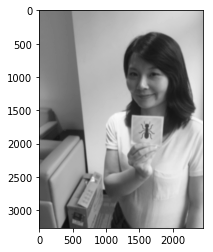

In [8]:
plt.imshow(img, cmap='gray', interpolation='bicubic')

In [9]:
blurred = cv2.GaussianBlur(img,(9,9),0)

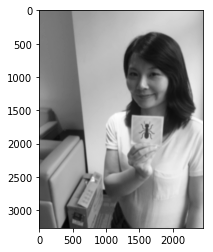

In [10]:
plt.imshow(blurred, cmap='gray', interpolation='bicubic')

In [11]:
gradX = cv2.Sobel(img,ddepth=cv2.CV_32F, dx=1,dy=0)
gradY = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1)
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

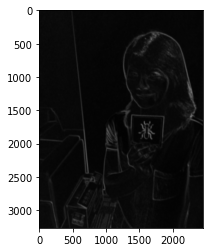

In [12]:
plt.imshow(gradient, cmap='gray', interpolation='bicubic')

In [14]:
a = cv2.Canny(img, 0, 60, apertureSize=3)

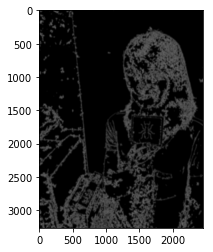

In [15]:
plt.imshow(a, cmap='gray', interpolation='bicubic')

In [18]:
import math
class Config:
    def __init__(self):
        pass

    src = "test18.png"
    min_area = 100000
    min_contours = 8
    threshold_thresh = 50
    epsilon_start = 50
    epsilon_step = 10

class HoughPoints:
    def __init__(self,rho=0,theta=0):
        self.rhos = [rho]
        self.thetas = [theta]

'''
@func       根据HoughLines转换出直线点
@param      rho 距离
@param      theta 角度
'''
def rt_to_point(img, rho, theta):
    #垂直直线
    if (theta < (np.pi/4. )) or (theta > (3.*np.pi/4.0)):
        #该直线与第一行的交点
        pt1 = (int(rho/np.cos(theta)),0)
        #该直线与最后一行的焦点
        pt2 = (int((rho-img.shape[0]*np.sin(theta))/np.cos(theta)),img.shape[0])
        return pt1, pt2
    else:
        #水平直线,  该直线与第一列的交点
        pt1 = (0,int(rho/np.sin(theta)))
        #该直线与最后一列的交点
        pt2 = (img.shape[1], int((rho-img.shape[1]*np.cos(theta))/np.sin(theta)))
        return pt1, pt2

'''
@return     [top-left, top-right, bottom-right, bottom-left]
'''
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def point_distance(a,b):
    return int(np.sqrt(np.sum(np.square(a - b))))

'''
@func   计算两条直线的交点
'''
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

'''
@func   迪卡尔转极坐标
'''
def cart_to_polor(x1, y1, x2, y2):
    diff = float(abs(x1-x2)) / abs(y1-y2)
    theta = math.atan(diff)
    #print("theta=%f, diff=%f, %f %f"%(theta, diff, abs(x1-x2), abs(y1-y2)))
    rho = math.sin(theta)*(y1 - (x1/math.tan(theta)) )
    return rho, theta

binary = a
_,contours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("len(contours)=%d"%(len(contours)))
for idx,c in enumerate(contours):
    if len(c) < Config.min_contours:
        continue

    epsilon = Config.epsilon_start
    while True:
        approx = cv2.approxPolyDP(c,epsilon,True)
        print("idx,epsilon,len(approx),len(c)=%d,%d,%d,%d"%(idx,epsilon,len(approx),len(c)))
        if (len(approx) < 4):
            break
        if math.fabs(cv2.contourArea(approx)) > Config.min_area:
            if (len(approx) > 4):
                epsilon += Config.epsilon_step
                print("epsilon=%d, count=%d"%(epsilon,len(approx)))
                continue
            else:
                #for p in approx:
                #    cv2.circle(binary,(p[0][0],p[0][1]),8,(255,255,0),thickness=-1)
                approx = approx.reshape((4, 2))
                # 点重排序, [top-left, top-right, bottom-right, bottom-left]
                src_rect = order_points(approx)

                cv2.drawContours(image, c, -1, (0,255,255),1)
                cv2.line(image, (src_rect[0][0],src_rect[0][1]),(src_rect[1][0],src_rect[1][1]),color=(100,255,100))
                cv2.line(image, (src_rect[2][0],src_rect[2][1]),(src_rect[1][0],src_rect[1][1]),color=(100,255,100))
                cv2.line(image, (src_rect[2][0],src_rect[2][1]),(src_rect[3][0],src_rect[3][1]),color=(100,255,100))
                cv2.line(image, (src_rect[0][0],src_rect[0][1]),(src_rect[3][0],src_rect[3][1]),color=(100,255,100))

                # 获取最小矩形包络
                rect = cv2.minAreaRect(approx)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
                box = box.reshape(4,2)
                box = order_points(box)
                print("approx->box")
                print(approx)
                print(src_rect)
                print(box)
                w,h = point_distance(box[0],box[1]), \
                      point_distance(box[1],box[2])
                print("w,h=%d,%d"%(w,h))
                # 透视变换
                dst_rect = np.array([
                    [0, 0],
                    [w - 1, 0],
                    [w - 1, h - 1],
                    [0, h - 1]],
                    dtype="float32")
                M = cv2.getPerspectiveTransform(src_rect, dst_rect)
                warped = cv2.warpPerspective(image, M, (w, h))
                cv2.imwrite("transfer%d.png"%idx, warped, [int(cv2.IMWRITE_PNG_COMPRESSION), 9])
                break
        else:
            print("failed %d area=%f"%(idx, math.fabs(cv2.contourArea(approx))))
            break

len(contours)=5974
idx,epsilon,len(approx),len(c)=3,50,1,8
idx,epsilon,len(approx),len(c)=7,50,1,11
idx,epsilon,len(approx),len(c)=16,50,1,17
idx,epsilon,len(approx),len(c)=17,50,1,12
idx,epsilon,len(approx),len(c)=18,50,1,12
idx,epsilon,len(approx),len(c)=21,50,1,10
idx,epsilon,len(approx),len(c)=23,50,1,10
idx,epsilon,len(approx),len(c)=24,50,1,25
idx,epsilon,len(approx),len(c)=25,50,1,18
idx,epsilon,len(approx),len(c)=26,50,1,17
idx,epsilon,len(approx),len(c)=28,50,1,8
idx,epsilon,len(approx),len(c)=30,50,1,16
idx,epsilon,len(approx),len(c)=31,50,1,22
idx,epsilon,len(approx),len(c)=32,50,1,30
idx,epsilon,len(approx),len(c)=33,50,1,10
idx,epsilon,len(approx),len(c)=34,50,1,16
idx,epsilon,len(approx),len(c)=35,50,1,32
idx,epsilon,len(approx),len(c)=36,50,1,25
idx,epsilon,len(approx),len(c)=37,50,1,74
idx,epsilon,len(approx),len(c)=40,50,1,11
idx,epsilon,len(approx),len(c)=41,50,1,32
idx,epsilon,len(approx),len(c)=42,50,1,50
idx,epsilon,len(approx),len(c)=43,50,1,28
idx,epsilon,len(app

idx,epsilon,len(approx),len(c)=1805,50,1,14
idx,epsilon,len(approx),len(c)=1808,50,1,220
idx,epsilon,len(approx),len(c)=1810,50,1,84
idx,epsilon,len(approx),len(c)=1812,50,1,28
idx,epsilon,len(approx),len(c)=1816,50,2,153
idx,epsilon,len(approx),len(c)=1819,50,1,16
idx,epsilon,len(approx),len(c)=1825,50,1,16
idx,epsilon,len(approx),len(c)=1827,50,1,28
idx,epsilon,len(approx),len(c)=1829,50,1,34
idx,epsilon,len(approx),len(c)=1831,50,1,44
idx,epsilon,len(approx),len(c)=1832,50,1,17
idx,epsilon,len(approx),len(c)=1835,50,1,34
idx,epsilon,len(approx),len(c)=1841,50,1,33
idx,epsilon,len(approx),len(c)=1842,50,1,67
idx,epsilon,len(approx),len(c)=1843,50,1,28
idx,epsilon,len(approx),len(c)=1844,50,2,463
idx,epsilon,len(approx),len(c)=1845,50,1,9
idx,epsilon,len(approx),len(c)=1846,50,1,32
idx,epsilon,len(approx),len(c)=1847,50,1,87
idx,epsilon,len(approx),len(c)=1848,50,2,989
idx,epsilon,len(approx),len(c)=1850,50,1,21
idx,epsilon,len(approx),len(c)=1854,50,2,909
idx,epsilon,len(approx),len(

idx,epsilon,len(approx),len(c)=3949,50,1,123
idx,epsilon,len(approx),len(c)=3950,50,2,65
idx,epsilon,len(approx),len(c)=3951,50,1,19
idx,epsilon,len(approx),len(c)=3952,50,2,321
idx,epsilon,len(approx),len(c)=3953,50,1,8
idx,epsilon,len(approx),len(c)=3954,50,1,66
idx,epsilon,len(approx),len(c)=3956,50,1,54
idx,epsilon,len(approx),len(c)=3957,50,1,17
idx,epsilon,len(approx),len(c)=3958,50,2,140
idx,epsilon,len(approx),len(c)=3959,50,1,32
idx,epsilon,len(approx),len(c)=3960,50,2,293
idx,epsilon,len(approx),len(c)=3961,50,2,341
idx,epsilon,len(approx),len(c)=3963,50,1,40
idx,epsilon,len(approx),len(c)=3964,50,2,570
idx,epsilon,len(approx),len(c)=3966,50,2,585
idx,epsilon,len(approx),len(c)=3967,50,1,20
idx,epsilon,len(approx),len(c)=3972,50,1,36
idx,epsilon,len(approx),len(c)=3974,50,2,238
idx,epsilon,len(approx),len(c)=3979,50,1,13
idx,epsilon,len(approx),len(c)=3983,50,1,11
idx,epsilon,len(approx),len(c)=3986,50,1,19
idx,epsilon,len(approx),len(c)=3989,50,1,13
idx,epsilon,len(approx),l

idx,epsilon,len(approx),len(c)=5915,50,1,177
idx,epsilon,len(approx),len(c)=5916,50,1,60
idx,epsilon,len(approx),len(c)=5917,50,2,577
idx,epsilon,len(approx),len(c)=5918,50,1,234
idx,epsilon,len(approx),len(c)=5919,50,1,12
idx,epsilon,len(approx),len(c)=5920,50,2,304
idx,epsilon,len(approx),len(c)=5921,50,1,39
idx,epsilon,len(approx),len(c)=5925,50,1,80
idx,epsilon,len(approx),len(c)=5926,50,1,32
idx,epsilon,len(approx),len(c)=5927,50,1,75
idx,epsilon,len(approx),len(c)=5928,50,2,590
idx,epsilon,len(approx),len(c)=5929,50,1,62
idx,epsilon,len(approx),len(c)=5931,50,1,130
idx,epsilon,len(approx),len(c)=5933,50,1,11
idx,epsilon,len(approx),len(c)=5934,50,1,20
idx,epsilon,len(approx),len(c)=5935,50,2,532
idx,epsilon,len(approx),len(c)=5936,50,1,39
idx,epsilon,len(approx),len(c)=5937,50,1,122
idx,epsilon,len(approx),len(c)=5938,50,1,100
idx,epsilon,len(approx),len(c)=5939,50,1,168
idx,epsilon,len(approx),len(c)=5940,50,2,335
idx,epsilon,len(approx),len(c)=5942,50,1,139
idx,epsilon,len(appr

In [20]:
plt.imshow(image, cmap='gray', interpolation='bicubic')

NameError: name 'image' is not defined

In [10]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
img=cv.imread('/Users/miracle/Documents/图片/miracleBackground/ayiyokueve_011401.png')

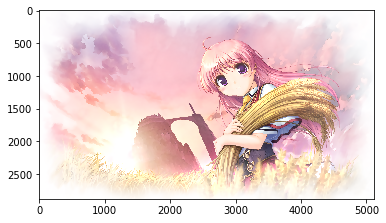

In [13]:
plt.imshow(img[:,:,::-1])